In [17]:
import numpy as np
import pints
import pints.plot
import pints_smol_moments_6_normalised_jit as toy
import matplotlib.pyplot as plt
from scipy.stats import moment
import pandas as pd



Select the desired model, true parameters and time array.

Then simulate to get synthetic data

In [18]:

model = toy.SmolModel(None,None)


true_parameters = [0.0003, 900]


times = np.linspace(20, 97, 78)

df = pd.read_csv('s11_inference_input_multi_well_t_20.csv', header=None)
org_values = np.transpose(df.to_numpy())


# 1st moment is mean, 1st centred moment should be array 6
centred_moment_1 = moment(org_values, moment=1, axis=1)
centred_moment_2 = moment(org_values, moment=2, axis=1)
centred_moment_3 = moment(org_values, moment=3, axis=1)
centred_moment_4 = moment(org_values, moment=4, axis=1)
centred_moment_5 = moment(org_values, moment=5, axis=1)
centred_moment_6 = moment(org_values, moment=6, axis=1)

# Out array, mean, variance then centred standardised moments (aka skewness, kurtosis, hyperskewness)
st_dev = np.sqrt(centred_moment_2)
out_array = np.zeros((78,6))
out_array[:,0] = np.mean(org_values,axis=1)
out_array[:,1] = centred_moment_2
out_array[:,2] = np.divide(centred_moment_3,st_dev*st_dev*st_dev)
out_array[:,3] = np.divide(centred_moment_4,st_dev*st_dev*st_dev*st_dev)
out_array[:,4] = np.divide(centred_moment_5,st_dev*st_dev*st_dev*st_dev*st_dev)
out_array[:,5] = np.divide(centred_moment_6,st_dev*st_dev*st_dev*st_dev*st_dev*st_dev)

# print(st_dev)

# print(np.mean(org_values, axis=1))
# print(centred_moment_3)




Add noise to the data (using random sampling from normal distribution)

In [19]:

# noise = 9
# values = org_values + np.random.normal(0, noise, org_values.shape)

size_noise = 6
noise_value = 1
# # Create a list with the specified size filled with a placeholder value
noise_arr = [noise_value for _ in range(size_noise)]
# noise_arr[0] = 1
# noise_arr[1] = 1
# noise_arr[2] = 1
# noise_arr[3] = 1
# noise_arr[4] = 1


Set-up pints problem and log likelihoods

In [20]:

# problem = pints.MultiOutputProblem(model, times, centred_moments)
problem = pints.MultiOutputProblem(model, times, out_array)

log_likelihood = pints.GaussianLogLikelihood(problem)
# log_likelihood_2 = pints.GaussianIntegratedLogUniformLogLikelihood(problem)

print('Original problem dimension: ' + str(problem.n_parameters()))
print('New dimension: ' + str(log_likelihood.n_parameters()))
# print('New dimension: ' + str(log_likelihood_2.n_parameters()))

true_parameters += noise_arr
# print(true_parameters)



Original problem dimension: 2
New dimension: 8


Create uniform log prior

In [21]:

# Define the size of the list
size = 8
placeholder_lower_value = 0
placeholder_upper_value = 1000
 
# Create a list with the specified size filled with a placeholder value
prior_arr_lower = [placeholder_lower_value for _ in range(size)]
prior_arr_upper = [placeholder_upper_value for _ in range(size)]
prior_arr_lower[0] = 0.00001
prior_arr_upper[0] = 0.001
prior_arr_lower[1] = 1
prior_arr_upper[1] = 4000
prior_arr_lower[2] = 0
prior_arr_upper[2] = 100
prior_arr_lower[3] = 0
prior_arr_upper[3] = 100
prior_arr_lower[4] = 0
prior_arr_upper[4] = 100
prior_arr_lower[5] = 0
prior_arr_upper[5] = 100
prior_arr_lower[6] = 0
prior_arr_upper[6] = 100
prior_arr_lower[7] = 0
prior_arr_upper[7] = 100


# log_prior = pints.UniformLogPrior(
#     [0.000001, 1, 1],
#     [0.01, 10000, 100]
#     )
log_prior = pints.UniformLogPrior(
    prior_arr_lower,
    prior_arr_upper
    )

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)


/var/folders/lt/9g_w308946v4x_5mqxc951qr0000gr/T/ipykernel_26910/1026962194.py:31: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(


In [22]:

xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]
ITERS = 10000
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.SliceDoublingMCMC)
mcmc.set_max_iterations(ITERS)
chains = mcmc.run()
print(chains)



Using Slice Sampling - Doubling
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.0
1     600     0:01.6
2     1203    0:03.4
3     1773    0:05.3
20    10119   0:30.7
40    18324   0:56.9
60    25650   1:20.6
80    33045   1:44.1
100   40464   2:07.8
120   47874   2:31.8
140   55065   2:55.2
160   62514   3:19.5
180   70008   3:44.0
200   77532   4:07.9
220   84948   4:31.8
240   92457   4:55.9
260   99690   5:19.1
280   107349   5:43.6
300   114822   6:07.2
320   122514   6:31.7
340   129852   6:55.1
360   137235   7:18.8
380   144702   7:42.4
400   152103   8:05.7
420   159402   8:28.7
440   166962   8:52.6
460   174036   9:15.4
480   181248   9:38.8
500   188634  10:02.6
520   195717  10:25.8
540   203289  10:50.0
560   210900  11:14.3
580   218037  11:36.7
600   225636  12:01.2
620   233073  12:24.9
640   240603  12:49.3
660   247941  13:12.5
680   255414  13:36.6
700   262587  13:59.4
720   270288  14:23.9
740   277452  14:46.9
760   284679 

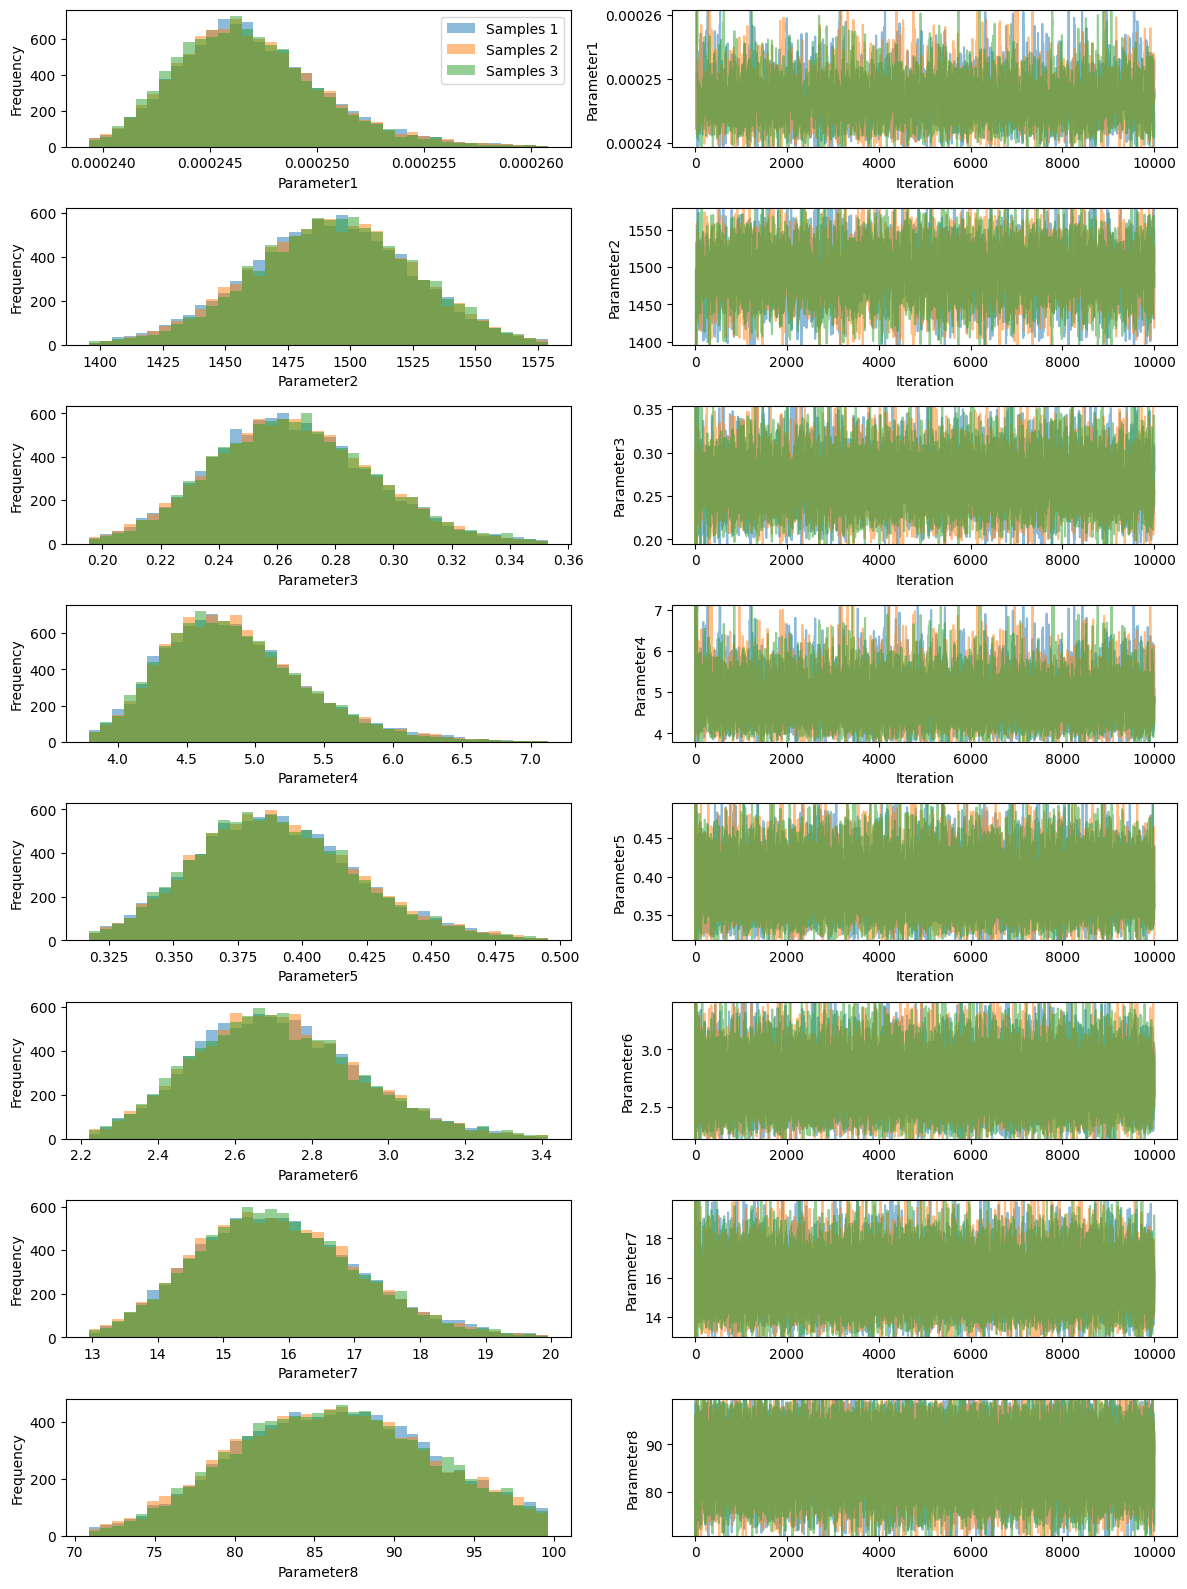

In [23]:

pints.plot.trace(chains, n_percentiles=99)
plt.savefig("mcmc.png")
plt.show()


In [24]:

# ITERS = 100
AllChains = chains[0,100:1000,:]
# np.asarray(AllChains)
print(np.shape(AllChains))
print(AllChains[0])
print(AllChains)


(900, 8)
[2.46803453e-04 1.49899275e+03 2.74748966e-01 4.63896780e+00
 4.12114611e-01 3.25399582e+00 1.65770494e+01 8.09175931e+01]
[[2.46803453e-04 1.49899275e+03 2.74748966e-01 ... 3.25399582e+00
  1.65770494e+01 8.09175931e+01]
 [2.45501263e-04 1.51272757e+03 2.75667416e-01 ... 2.49355275e+00
  1.51877546e+01 8.28302612e+01]
 [2.45721667e-04 1.51939112e+03 2.67536427e-01 ... 2.76552451e+00
  1.46474539e+01 8.21671706e+01]
 ...
 [2.45543319e-04 1.48020698e+03 2.91521915e-01 ... 2.94423432e+00
  1.48807021e+01 8.44884547e+01]
 [2.47703102e-04 1.52342903e+03 2.41746121e-01 ... 2.75951745e+00
  1.70516082e+01 8.17514171e+01]
 [2.42702076e-04 1.52149007e+03 2.45018849e-01 ... 2.72911103e+00
  1.77019932e+01 8.23261037e+01]]


In [25]:

for I in range(3-1):
    AllChains_add = chains[I+1,100:1000,:]
    AllChains = np.concatenate((AllChains,AllChains_add), axis=0)


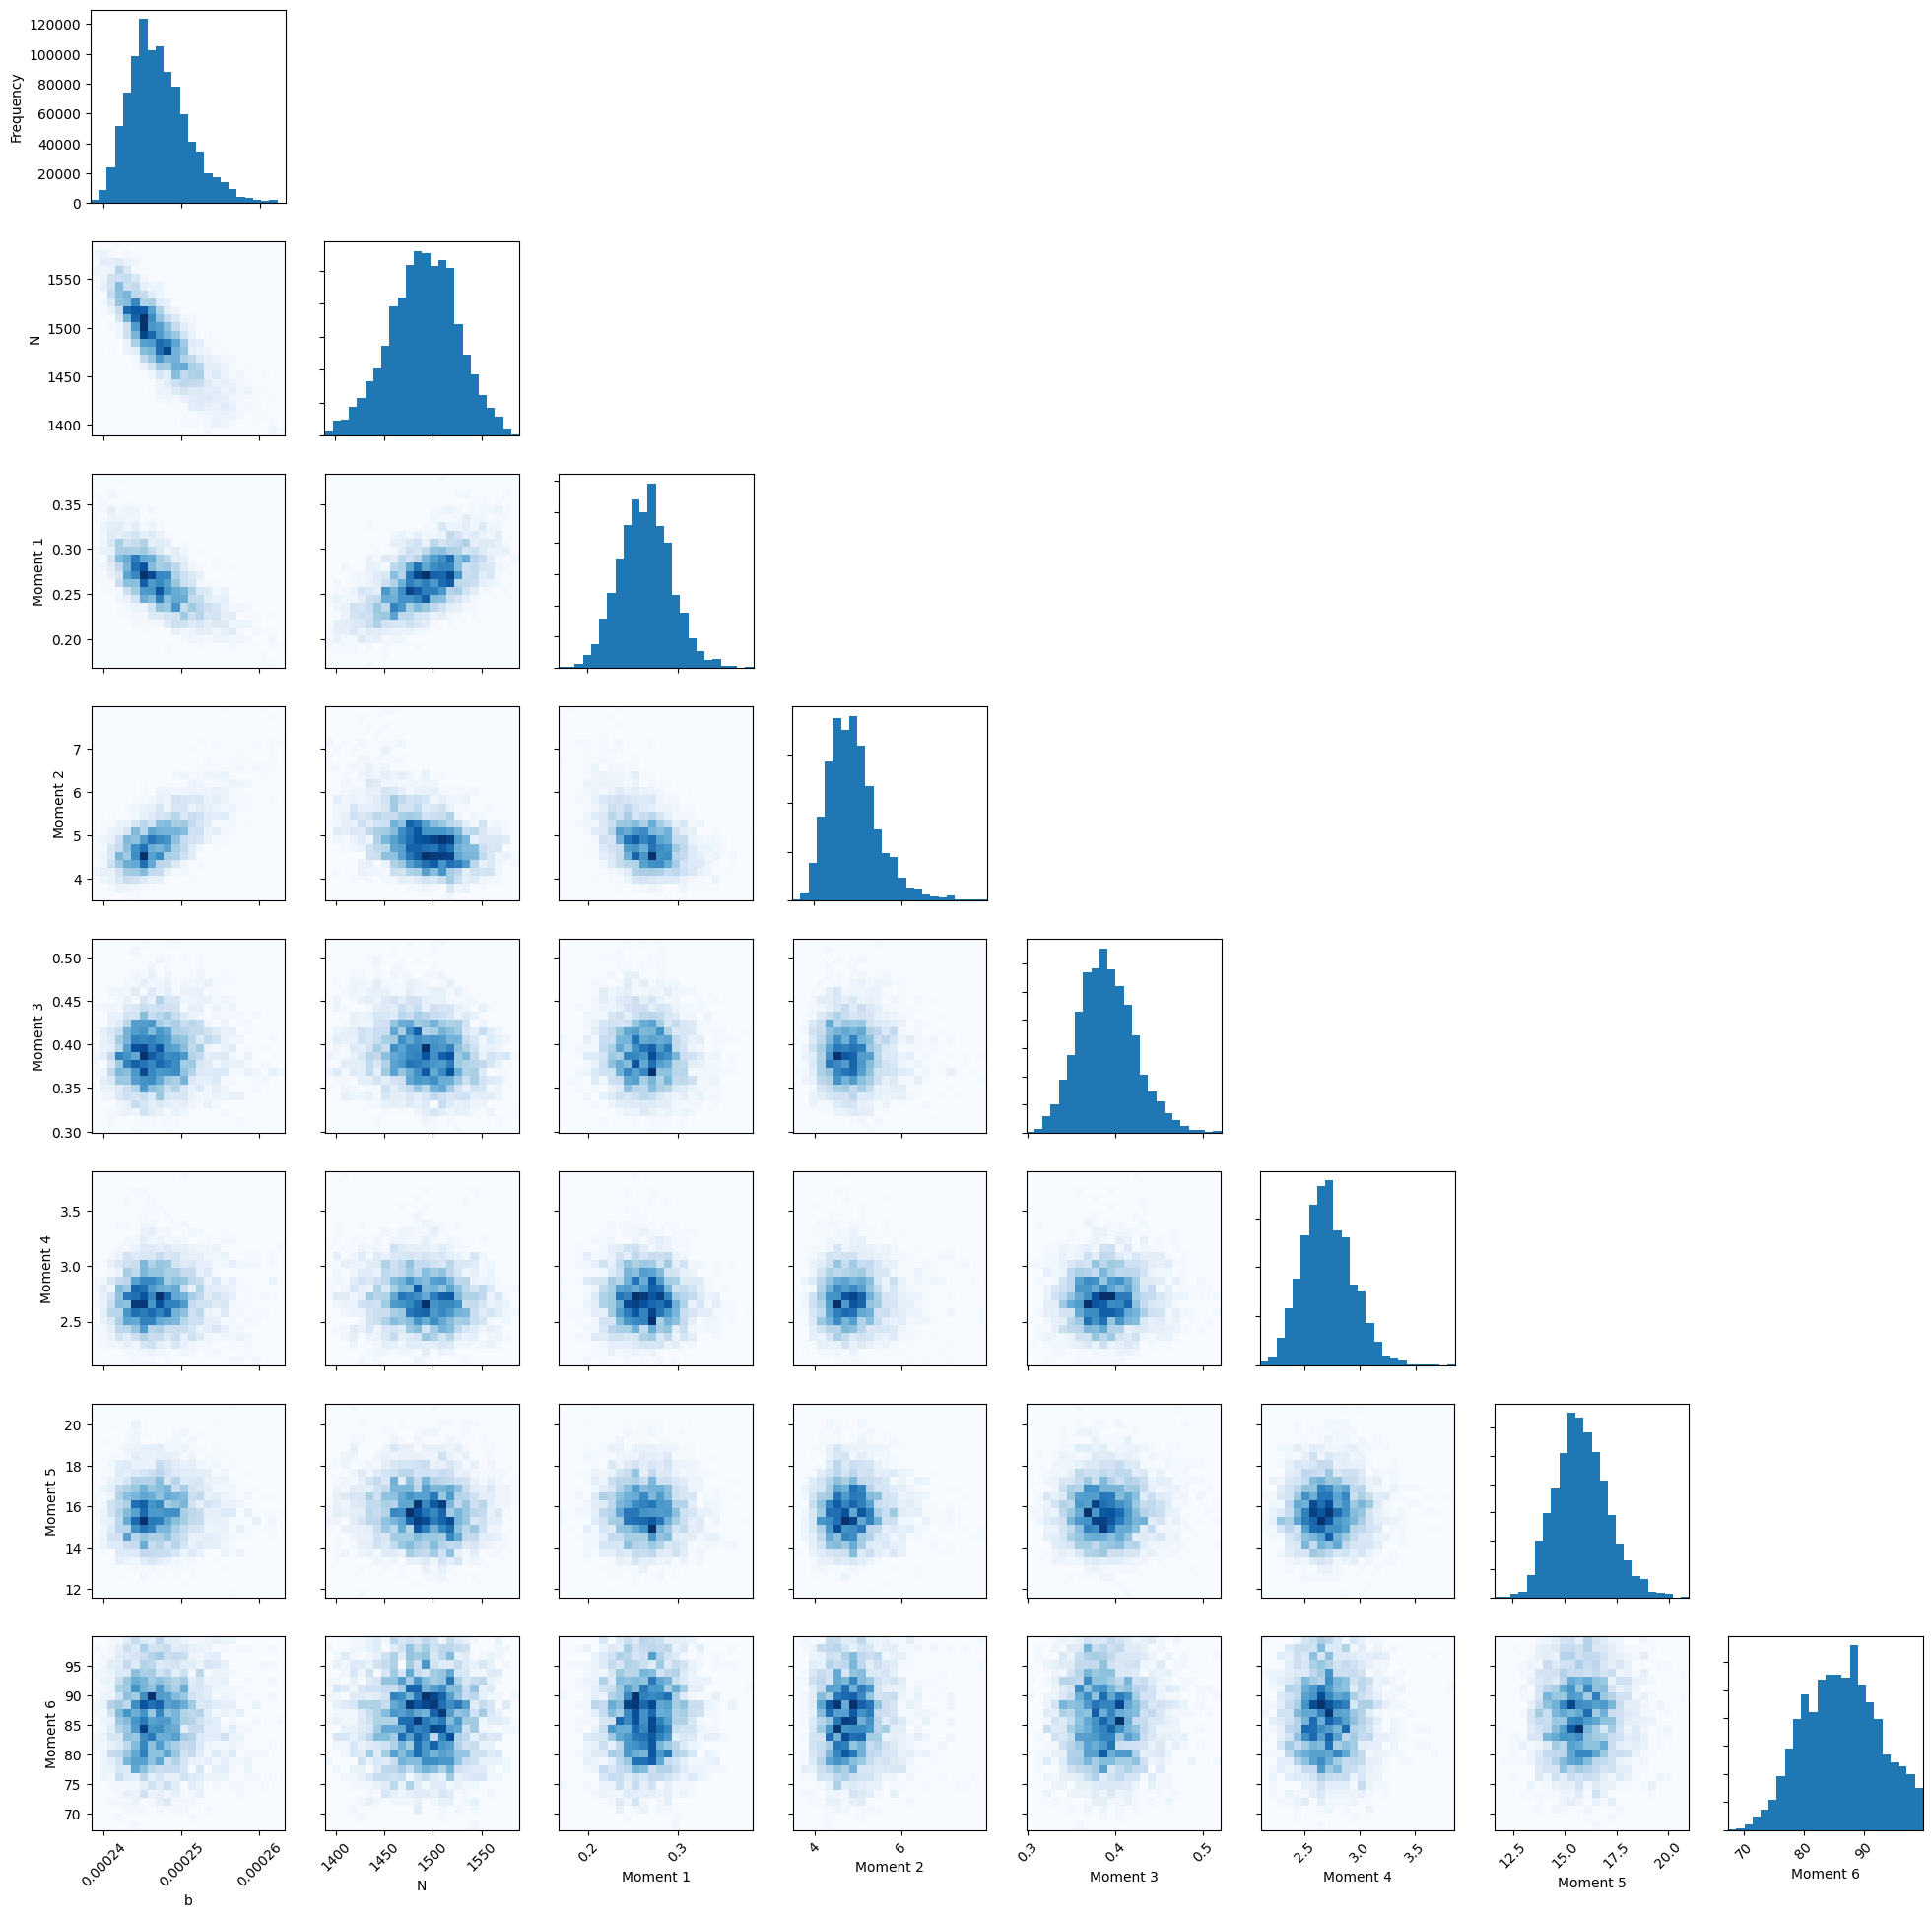

In [26]:


parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5", "Moment 6"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5", "Moment 6"])
plt.show()

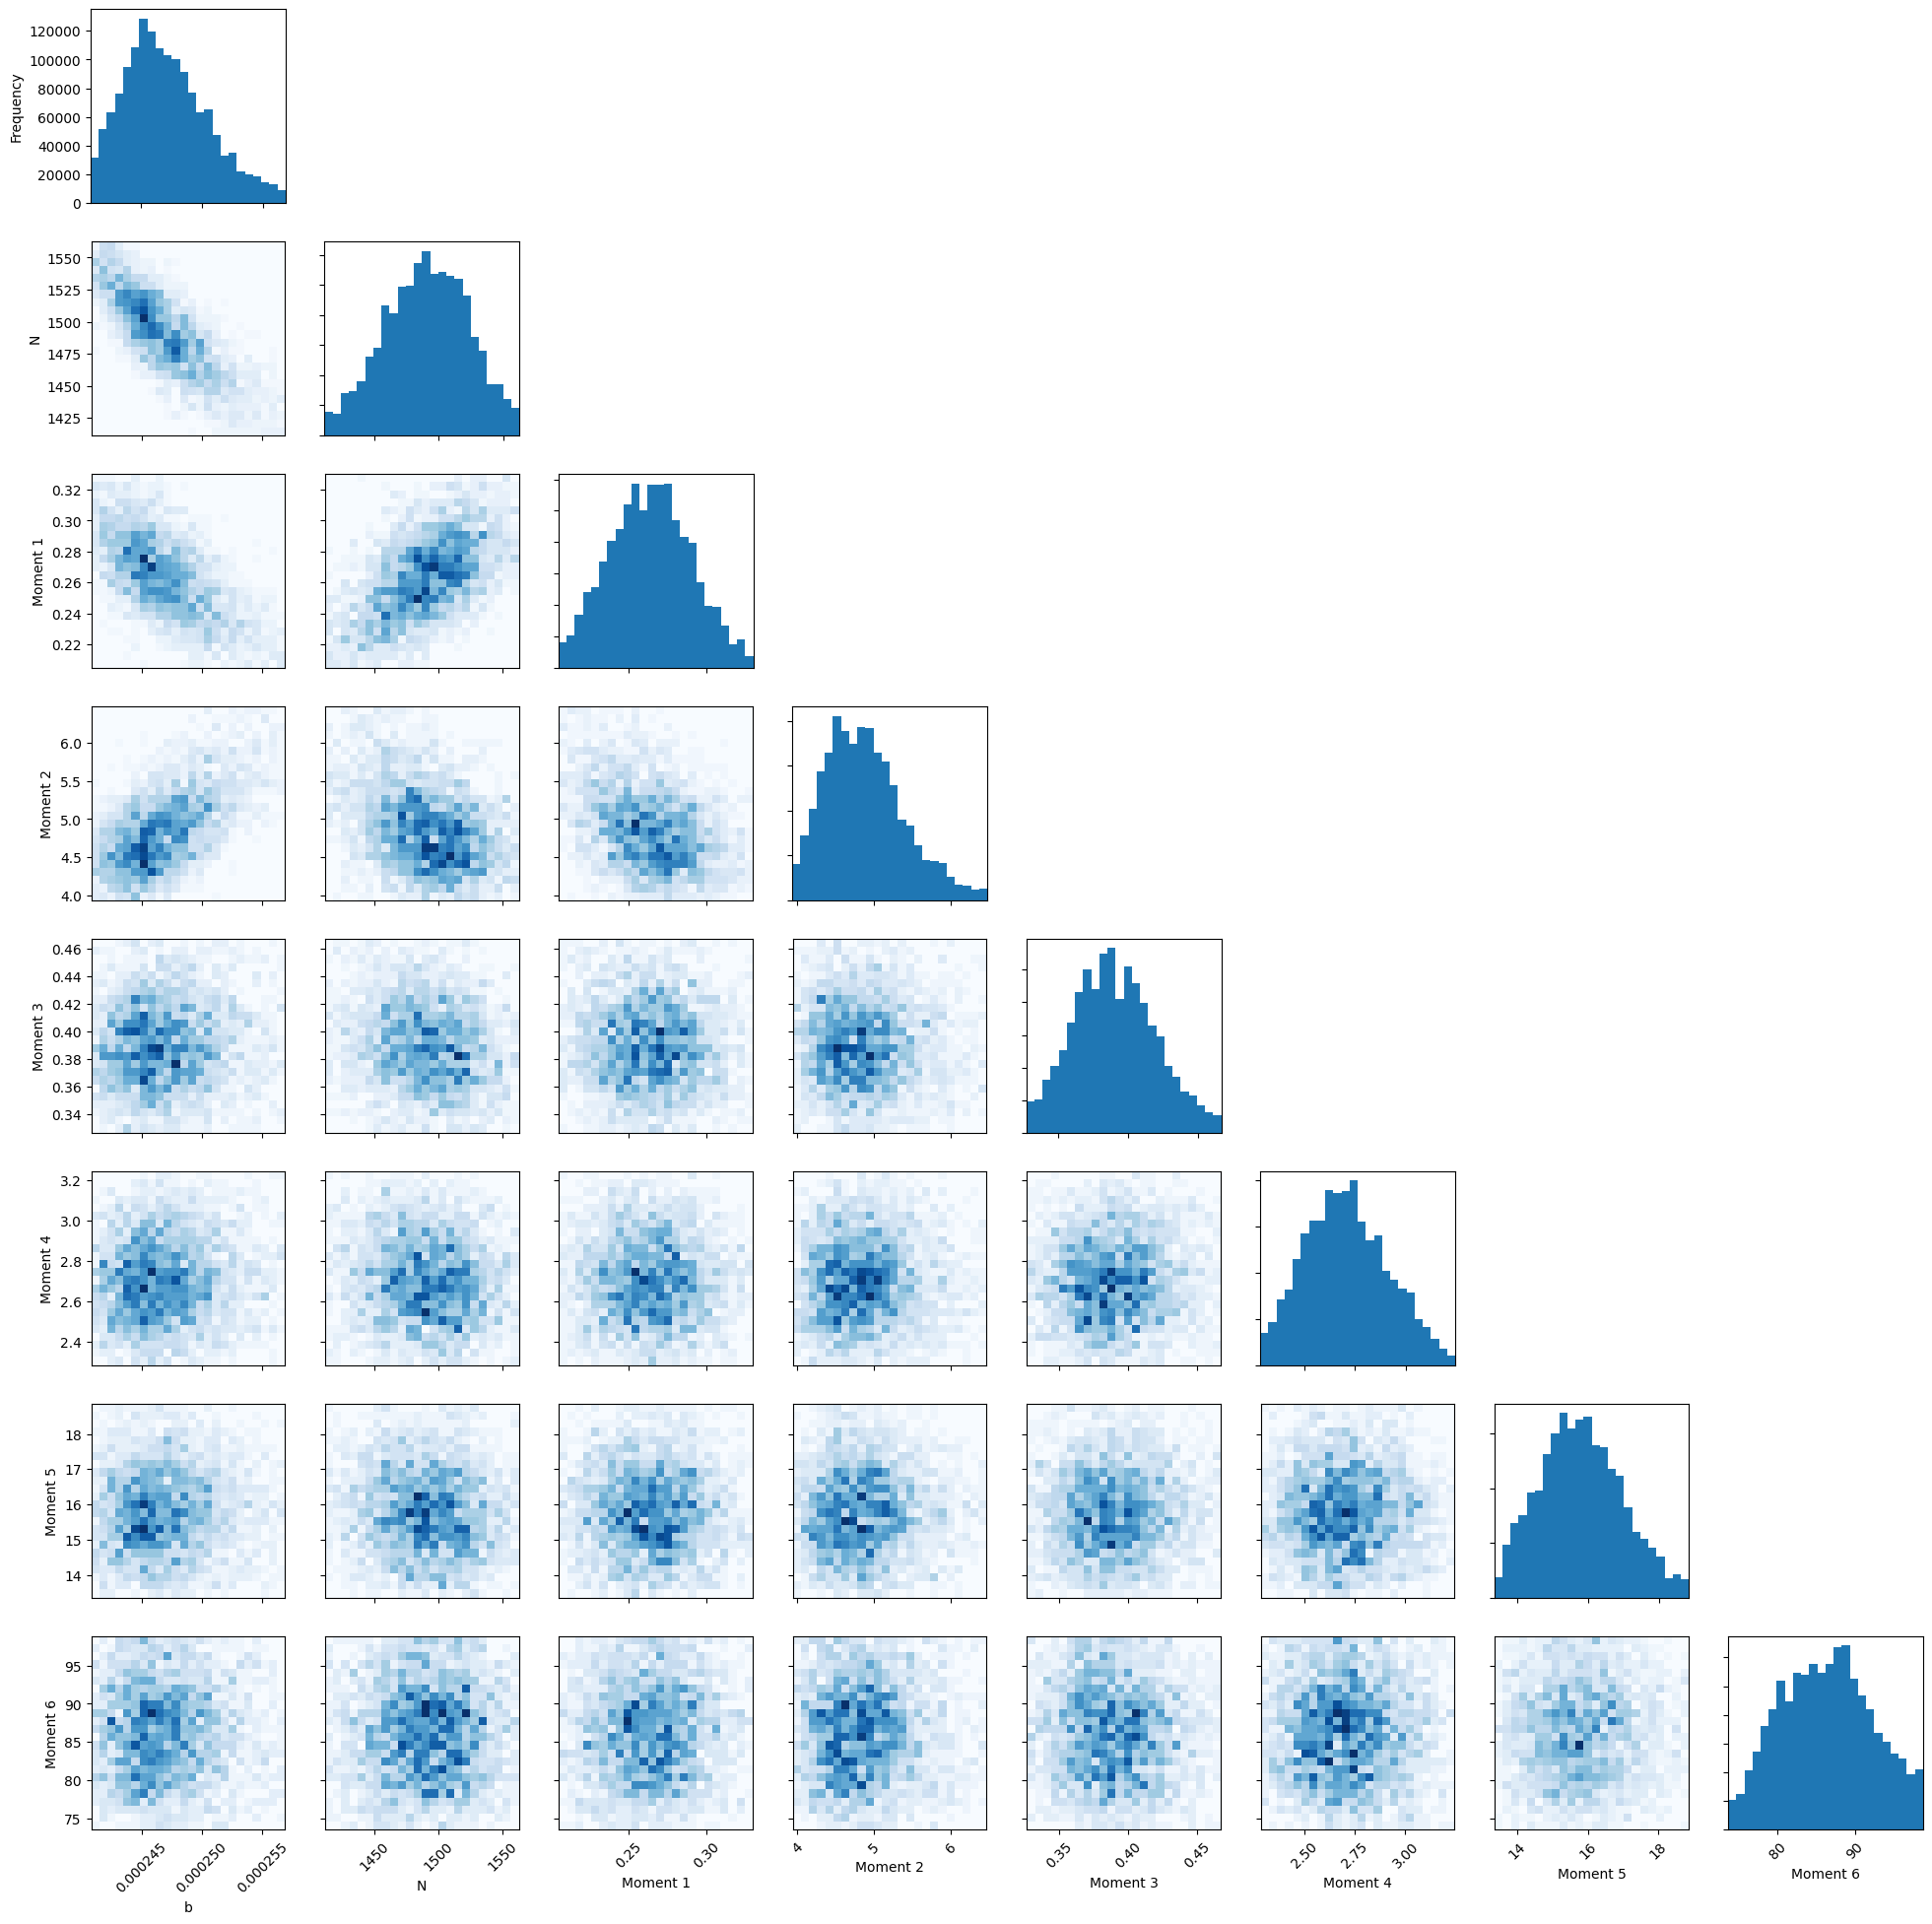

In [27]:
parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5", "Moment 6"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5", "Moment 6"],
                    n_percentiles=97)
                    
plt.show()

[2.46803453e-04 1.49899275e+03 2.74748966e-01 4.63896780e+00
 4.12114611e-01 3.25399582e+00 1.65770494e+01 8.09175931e+01]


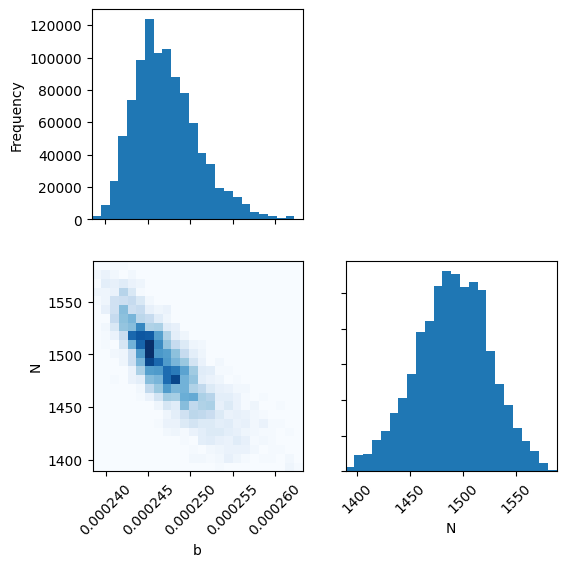

In [28]:
parameter_names = ["b","N"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)
print(AllChains[0])
pints.plot.pairwise(AllChains[:,[0,1]], heatmap=True, 
                    parameter_names=["b","N"])
plt.savefig("Pints_pairwise.png", dpi =300)
plt.show()


In [29]:
parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5", "Moment 6"]
results = pints.MCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)


<class 'pints._mcmc._summary.MCMCSummary'>
param     mean     std.    2.5%     25%      50%      75%      97.5%    rhat    ess      ess per sec.
--------  -------  ------  -------  -------  -------  -------  -------  ------  -------  --------------
b         0.00     0.00    0.00     0.00     0.00     0.00     0.00     1.00    1339.10  0.11
N         1492.20  33.39   1425.40  1470.06  1492.58  1514.36  1556.36  1.00    1575.95  0.13
Moment 1  0.27     0.03    0.21     0.25     0.26     0.28     0.33     1.00    2052.41  0.17
Moment 2  4.85     0.54    3.98     4.47     4.79     5.16     6.12     1.00    1957.48  0.17
Moment 3  0.39     0.03    0.33     0.37     0.39     0.41     0.46     1.00    4597.10  0.39
Moment 4  2.71     0.22    2.32     2.56     2.69     2.85     3.20     1.00    4740.82  0.40
Moment 5  15.84    1.28    13.57    14.93    15.75    16.65    18.57    1.00    4709.91  0.40
Moment 6  86.23    6.23    74.38    81.73    86.22    90.73    98.08    1.00    4450.89  0.38

In [30]:
from tabulate import tabulate
class MyMCMCSummary(pints.MCMCSummary):
    def __str__(self):
        """
        Prints posterior summaries for all parameters to the console, including
        the parameter name, posterior mean, posterior std deviation, the
        2.5%, 25%, 50%, 75% and 97.5% posterior quantiles, rhat, effective
        sample size (ess) and ess per second of run time.
        """
        if self._summary_str is None:
            headers = [
                'param', 'mean', 'std.',
                '2.5%', '25%', '50%', '75%', '97.5%',
                'rhat', 'ess']
            if self._time is not None:
                headers.append('ess per sec.')

            self._summary_str = tabulate(
                self._summary_list,
                headers=headers,
                numalign='left',
                floatfmt='.3g',
            )

        return self._summary_str
    


In [31]:

parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5", "Moment 6"]
results = MyMCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)

<class '__main__.MyMCMCSummary'>
param     mean      std.      2.5%      25%       50%       75%       97.5%     rhat    ess       ess per sec.
--------  --------  --------  --------  --------  --------  --------  --------  ------  --------  --------------
b         0.000247  3.52e-06  0.000241  0.000244  0.000247  0.000249  0.000255  1       1.34e+03  0.114
N         1.49e+03  33.4      1.43e+03  1.47e+03  1.49e+03  1.51e+03  1.56e+03  1       1.58e+03  0.134
Moment 1  0.265     0.0288    0.212     0.246     0.264     0.283     0.326     1       2.05e+03  0.174
Moment 2  4.85      0.543     3.98      4.47      4.79      5.16      6.12      1       1.96e+03  0.166
Moment 3  0.39      0.0329    0.332     0.367     0.388     0.41      0.462     1       4.6e+03   0.391
Moment 4  2.71      0.223     2.32      2.56      2.69      2.85      3.2       1       4.74e+03  0.403
Moment 5  15.8      1.28      13.6      14.9      15.8      16.7      18.6      1       4.71e+03  0.4
Moment 6  86.2   

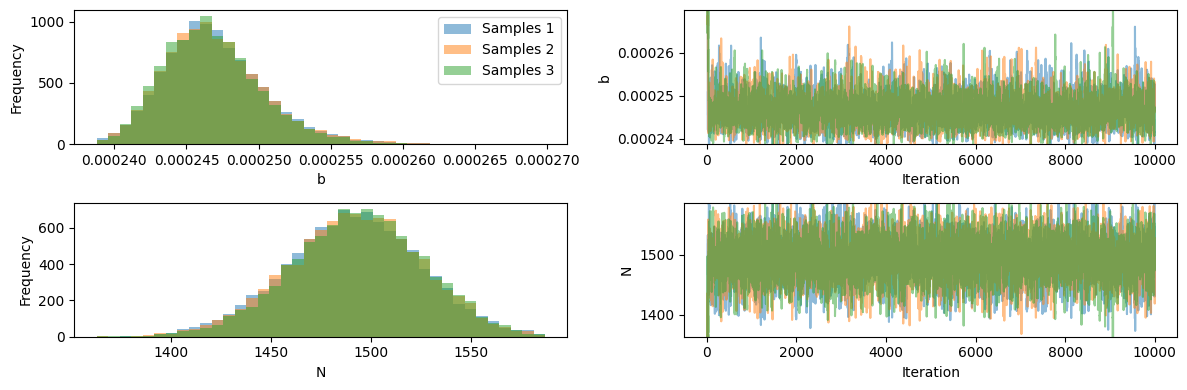

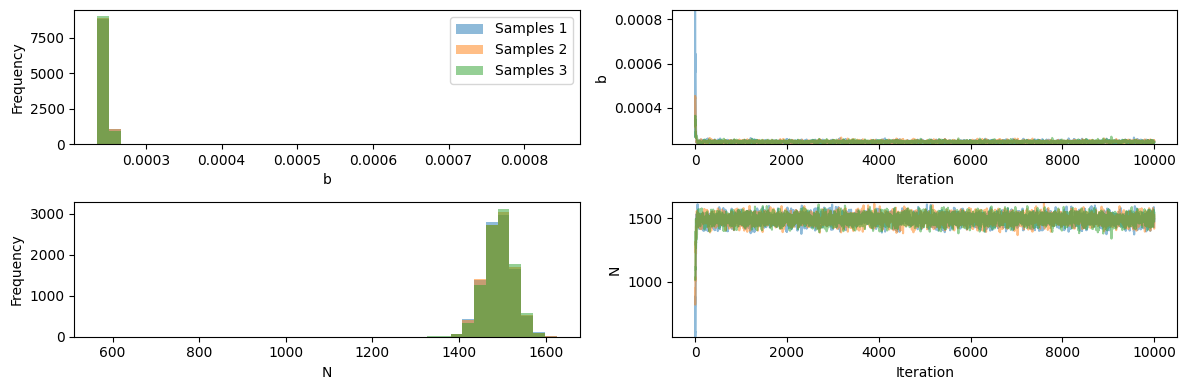

In [32]:
pints.plot.trace(chains[:,:,[0,1]], n_percentiles=99.5, parameter_names=["b","N"])
plt.savefig("pints_out_extremes_removed.png", dpi=300)
plt.show()
pints.plot.trace(chains[:,:,[0,1]], parameter_names=["b","N"])
plt.savefig("pints_out.png", dpi=300)
plt.show()